# Laboratorio 5
**Tutorial on data analysis and visualization**


Authors:
    
- Prof. Marco A. Deriu (marco.deriu@polito.it)
- Lorenzo Pallante (lorenzo.pallante@polito.it)
- Eric A. Zizzi (eric.zizzi@polito.it)
- Marcello Miceli (marcello.miceli@polito.it)
- Marco Cannariato (marco.cannariato@polito.it)

<div class="alert alert-block alert-warning">
<b>WARNING:</b> You will need a working instance of VMD (Visual Molecular Dynamics) v. 1.9.3 or higher on your machine!<br>
Please make sure to download (registration required) and install the software <b>before</b> attending the lab!<br>
More information and download:<br> https://www.ks.uiuc.edu/Development/Download/download.cgi?PackageName=VMD
</div>

# Table of Contents

1. Basic data formats and plotting
2. Performing data analysis in Python
3. Visualizing PDB files in Nglview
4. Visualizing PDB files in VMD (local)

**Learning outcomes:** 
- loading data from text files
- being able to create meaningful plots for easy data visualization
- being able to load, visualize and render 3D representations of molecular systems

# 1. Basic data formats and plotting

## 1.1 Loading data from text files
Other than in very specific applications, scientific data is often generated and shared in some form of ASCII text file. This means that such data files can be parsed (=read) and analyzed by virtually anyone, provided the data format is known.
As you might remember, reading a text file and saving its content into appropriate arrays is a relatively easy task in most programming languages, Python included. We will see a few examples now.

**REMINDER: Linux is an <u>extensionless system</u>, and generally speaking you should not be afraid of strange file extensions. If you know that a given file is an ASCII text file, then you can open it in the usual ways discussed in the following, whatever the extension (.txt, .dat, .in, .xvg, .out, ...)**

** Insert COLAB copy command **

Let's have a look at a basic, two-column text file containing time-series data:

In [1]:
import numpy as np
import seaborn as sns

### 1.1.1 Loading an ASCII file in python

In [5]:
lines=[]
f = open("data/apl.txt","r")
for line in f:
    lines.append(line)
f.close()

More compact and efficient way:

In [4]:
lines=[]
with open("data/apl.txt",'r') as f:
    for line in f:
        lines.append(line)

Now let's have a look at the content:

In [6]:
print("Fist line of the loaded file:")
print(lines[0])

Fist line of the loaded file:
250200.00 42.47



This file contains two columns, separated by a whitespace. The first column is the time (expressed in picoseconds in float), the second column is a quantity called "Area per Lipid", corrensponding by the average surface (in Angstrom^2) occupied by one phospholipid in a membrane simulation.


As we can see, we managed to separate individual lines into entries of a list, but we need to further separate the time (which could by our x value) and the APL (our y value to be analyzed). A pure python way to do this would be e.g. with the split method:

In [9]:
row1 = lines[0].split()
print(f"The time is {row1[0]} ps")
print(f"The APL value is {row1[1]} Å^2")

The time is 250200.00 ps
The APL value is 42.47 Å^2


We would need to do this operation for each line of the file, presumably in a loop:

In [11]:
vtimes = []
vapl = []
for el in lines:
    time = el.split()[0]
    apl = el.split()[1]
    vtimes.append(time)
    vapl.append(apl)


And now we have the individual columns as two different lists:

In [12]:
print(vtimes[0:11])
print(vapl[0:11])

['250200.00', '250400.00', '250600.00', '250800.00', '251000.00', '251200.00', '251400.00', '251600.00', '251800.00', '252000.00', '252200.00']
['42.47', '42.73', '42.44', '42.37', '42.36', '42.43', '42.55', '42.46', '42.33', '42.45', '42.71']


This method works, but has a few shortcomings:
* works for this specific file type (i.e, two columns separated by whitespace and no header, comments, metadata)
* it requires for loops (= inefficient)
* must be written from scratch each time (= time consuming)

Fortunately, most data processing libraries (numpy, pandas, ...) also usually have a builtin method/function to parse text files.<br>
The function bundled with numpy is<br>
```python
import numpy as np
arr = np.loadtxt(filename,usecols=...,max_rows=...,comments=...)
```

Let's see it in action on our text file:

In [16]:
import numpy as np
vtimes = np.loadtxt("data/apl.txt",usecols=(0),max_rows=1250)
vapl = np.loadtxt("data/apl.txt",usecols=(1),max_rows=1250)
print(vtimes[0:11])
print(vapl[0:11])
vtimes.dtype

[250200. 250400. 250600. 250800. 251000. 251200. 251400. 251600. 251800.
 252000. 252200.]
[42.47 42.73 42.44 42.37 42.36 42.43 42.55 42.46 42.33 42.45 42.71]


dtype('float64')

You can use the usual python magic inside the function (string substitutions, etc):
```python
root_folder = "data"
filename = "apl.txt"
vtimes = np.loadtxt(f"{root_folder}/{filename}",usecols=(0),max_rows=1250)
# Alternative:
vtimes = np.loadtxt("%s/%s" % (root_folder,filename),usecols=(0),max_rows=1250)
# ...
```

### 1.1.2 Loading and plotting XVG files

As you can see, this is much quicker to write. It is also way more flexible in dealing with filetypes with different separators, headers, comments, etc.
Let's open for example an <b>xvg</b> file, which is the file GROMACS writes when performing (most of the) analyses, containing the RMSD as a function of time.

Wait...what the hell is RMSD?<br>
You will see the details, but in a nutshell it is a metric that tells you "how different" two molecular structures are. Often, it is used to quantify the change of a given (macro)molecule in time as the atoms move, bonds and angles wiggle, and so on...<br>

Example: one water molecule evolving in time:<br>
<img src="data/SupplementaryAnimationRMSD.gif" width="750" align="center">

GROMACS calculates this quantity automatically for us, given a trajectory of a molecule in time. It saves the results into an xvg file. Let's have a look:

In [19]:
%%bash
head -n 20 data/rmsd.xvg

# This file was created Thu Dec 31 12:18:19 2020
# Created by:
#                   :-) GROMACS - gmx rms, 2020.4-MODIFIED (-:
# 
# Executable:   /opt/gromacs/2020.4/bin/gmx
# Data prefix:  /opt/gromacs/2020.4
# Working dir:  /home/studente/Multiscala/Input/models/00cady/punto4/md
# Command line:
#   gmx rms -s md.tpr -f md.trr -o rmsd.xvg
# gmx rms is part of G R O M A C S:
#
# Gyas ROwers Mature At Cryogenic Speed
#
@    title "RMSD"
@    xaxis  label "Time (ps)"
@    yaxis  label "RMSD (nm)"
@TYPE xy
@ subtitle "Protein after lsq fit to Backbone"
   0.0000000    0.0003260
   0.2000000    0.0817766


A couple of things to notice:
* The file has a header of 18 lines
* Lines starting with # are comments
* Lines starting with @ contain plotting instructions (e.g. for grace)
* Actual data starts at line 19, and the two columns are separated by 4 whitespaces

While we could read this file in pure python (skipping the first 18 lines, etc.), numpy makes it really easy:

In [25]:
comm = ["#","@"]
vtimes = np.loadtxt("data/rmsd.xvg",usecols=(0),comments=comm)
vrmsd = np.loadtxt("data/rmsd.xvg",usecols=(1),comments=comm)
# Or, even more compact:
vtimes, vrmsd =  np.loadtxt("data/rmsd.xvg",usecols=(0,1),comments=comm, unpack=True)
# Let's see the data:
print(vtimes[0:11])
print(vrmsd[0:11])


[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]
[3.260000e-04 8.177660e-02 1.676585e-01 2.471416e-01 2.944810e-01
 3.439816e-01 3.726170e-01 4.035859e-01 4.134620e-01 4.193570e-01
 4.291862e-01]


<div class="alert alert-block alert-info"><b>Nice little detail:</b><br> numpy already converted small numbers into scientific notation!</div>

Now that we have the data, we can first of all plot it, using matplotlib and/or seaborn. Seaborn is a matplotlib wrapper, which makes plotting a little bit easier thanks to its preset plotting functions which allow you to make nice plots with little adjustments.<br>
<div class="alert alert-block alert-warning"> Keep in mind that everything you do in seaborn can also be achieved using pure matplotlib. Also, a plot generated using seaborn is in fact a matplotlib plot, so all its attributes (title, axes, legends, etc.) are accessible using the matplotlib syntax! </div>

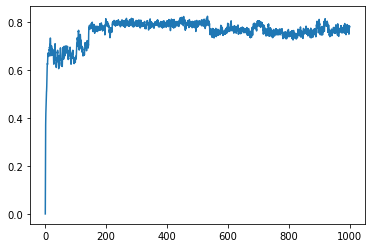

In [26]:
import matplotlib.pyplot as plt
# Example 1: using just matplotlib
plt.plot(vtimes,vrmsd)

This is a very basic plot. It can be further personalized though. Let's add a title, axis labels and maybe change the colors a bit:

Text(0, 0.5, 'RMSD (nm)')

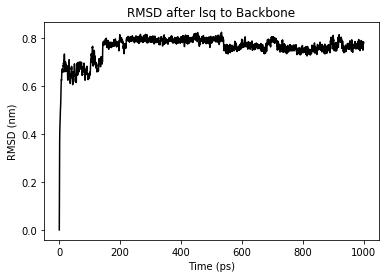

In [30]:
plt.plot(vtimes,vrmsd,'k')
plt.title("RMSD after lsq to Backbone")
plt.xlabel("Time (ps)")
plt.ylabel("RMSD (nm)")

Now let's try with Seaborn:

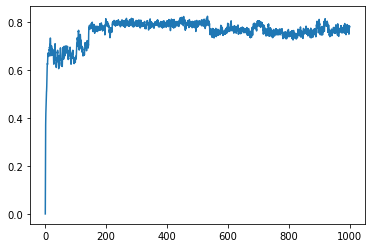

In [32]:
import seaborn as sns
sns.lineplot(x=vtimes,y=vrmsd)

As you can see, the plot is exaclty the same as the one generated using pure matplotlib. For these simple plots, matplotlib is sufficiently easy to create meaningful plots, so we'll stick to that.<br>
Let's adjust the plot a bit to explore some further possibilities. For example, let's plot just one every 100 datapoints to simplify the plot:

Text(0, 0.5, 'RMSD (nm)')

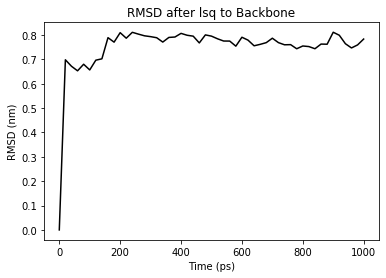

In [38]:
plt.plot(vtimes[::100],vrmsd[::100],'k')
plt.title("RMSD after lsq to Backbone")
plt.xlabel("Time (ps)")
plt.ylabel("RMSD (nm)")

We used pure python syntax (a thing called "slicing") to skip through a certain number of elements in the list.<br>
<div class="alert alert-block alert-warning"> <b>CAUTION:</b> the lists provided for x and y values must have the same length (just as in e.g. Matlab). Also, be careful that by skipping a certain number of elements, depending on the sampling frequency, you might miss some important parts of the dynamics of the system! </div>


## 1.2 Analyzing data

We now know how to import data from text files (including xvg files) and how to store them in python lists and numpy arrays.<br>
Now let's perform some analyses on the data.<br>
First let's look at the plot again:

Text(0, 0.5, 'RMSD (nm)')

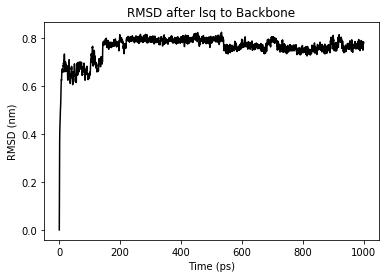

In [42]:
plt.plot(vtimes,vrmsd,'k')
plt.title("RMSD after lsq to Backbone")
plt.xlabel("Time (ps)")
plt.ylabel("RMSD (nm)")

It seems that some sort of equilibrium is reached after roughly 200 ps. So I might be interested in regarding the first 200 ps as a transient, and just keep and analyze the second part.<br>
I might be tempted do to something like:

In [44]:
newtimes = vtimes[0:201]
newrmsd = vrmsd[0:201]
newtimes[-1]

40.0

What? Why is the last time 40 ps? Shouldn't it be 200 ps?

Of course, the answer is that this particular property was not sampled every picosecond. Indeed, if we look at the first few elements of the time vector:

In [45]:
print(vtimes[0:11])

[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]


Since these values are expressed in picoseconds, it appears that this property was sampled (=measured) every 0.2 ps (200 fs). So first it might be convenient to find out how many steps i should consider. Usually, the reasoning is in time (ps) and not in number of datapoints, so let's define these things in our code so that life will be easier for us:

In [46]:
dt=1 # This delta time, in picoseconds, is the sampling that I want
tstart=200 # This value, in picoseconds, is my desiderd starting point:
tend=1000 # Same as above, my desired last timepoint

Now we write the rest of our code so that it uses the values above and does the conversions automatically:

Text(0, 0.5, 'RMSD (nm)')

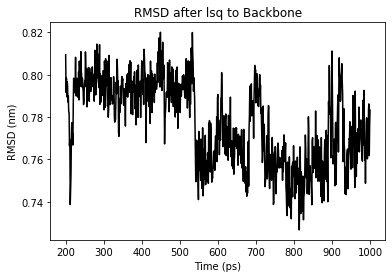

In [62]:
original_dt = vtimes[1]-vtimes[0] # This is the sampling period of the original data, in picoseconds
start_index = int(tstart/original_dt) # This is the index of the first datapoint that i should use
skip_index = int(dt/original_dt)
newtime = vtimes[start_index::skip_index]
newrmsd = vrmsd[start_index::skip_index]
# Now plot:
plt.plot(newtime,newrmsd,'k')
plt.title("RMSD after lsq to Backbone")
plt.xlabel("Time (ps)")
plt.ylabel("RMSD (nm)")

Notice the x axis, which now goes from 200 to 1000. Also notice the range of the y axis: it was from 0 to 0.85 nm before, while it is 0.72 to 0.83 now, and this makes the data look very different!<br>
We can manually use the old range:

(0, 0.85)

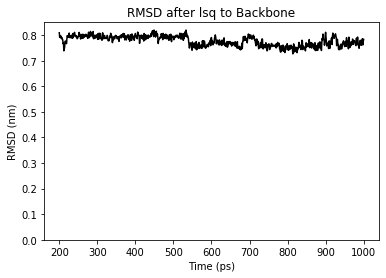

In [63]:
plt.plot(newtime,newrmsd,'k')
plt.title("RMSD after lsq to Backbone")
plt.xlabel("Time (ps)")
plt.ylabel("RMSD (nm)")
plt.ylim([0,0.85])

Ok, now we have only the last 800 ps of data, sampled with a frequency of 1 ps^(-1). We can now use the power of numpy to calculate some statistics on it:

In [69]:
import numpy as np
mean_rmsd = np.mean(newrmsd)
dev_rmsd = np.std(newrmsd)
print(f"The average RMSD value is: {mean_rmsd:.2f} +/- {dev_rmsd:.2f} nm")

The average RMSD value is: 0.78 +/- 0.02 nm


Let's compare these quantities with the same calculated from t=0:

In [81]:
import numpy as np
mean_rmsd2 = np.mean(vrmsd)
dev_rmsd2 = np.std(vrmsd)
print(f"The average RMSD value is: {mean_rmsd2:.2f} +/- {dev_rmsd2:.2f} nm")

The average RMSD value is: 0.76 +/- 0.05 nm


As you can see values are slightly shifted due to the initial transient. Let's compare the two using a bar plot:

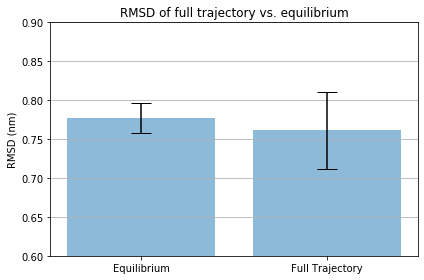

In [91]:
# Create lists for the plot
dataseries = ['Equilibrium', 'Full Trajectory']
x_pos = np.arange(len(dataseries))
means = [mean_rmsd,mean_rmsd2]
devs = [dev_rmsd, dev_rmsd2]
# Now we build the plot a set a couple of options to make it look nice:
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=devs, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('RMSD (nm)')
ax.set_xticks(x_pos)
ax.set_xticklabels(dataseries)
ax.set_title('RMSD of full trajectory vs. equilibrium')
ax.yaxis.grid(True)
ax.set_ylim((0.6,0.9))
# Save the figure and show
plt.tight_layout()
plt.savefig('rmsd_comparison.png')
plt.show()

### 1.2.1 EXERCISE
Using the same procedure, load the data contained in the file "apl.txt" into numpy arrays. Create and save two simple line plots containing the time evolution of the APL starting from t=250200 ps (series 1) and t=300000 ps (series 2). Use a sampling of 1000 ps (= 1ns). 
Then, compare the mean and standard deviation of the two time series 1 and 2 and plot them with error bars using a bar plot. Save this bar plot as "apl_comparison.png" in the "data" directory.

To have a smoother visualization of the data, e.g. to remove unrelevant noise from rapid fluctuations, we have one more option aside from skipping every N datapoints: the moving average.<br>
It is quite easy to calculate and plot a moving average from time series data in python, so let's do it!

<div class="alert alert-block alert-warning"> <b>CAREFUL:</b> Caculating moving averages is a neat way to clean up the data, but it is by all means a data manipulation! This means that it is not a good idea to use aggressive filtering (e.g. a moving average) to hide artifacts or weird behaviours! This is considered by all means data fabrication and constitues a form of scientific misconduct!<br>
So, it is a good idea to plot moving averages <b><u>above</b></u> the original timeseries, just for transparency.</div>

To exploit the speed and efficiency of the numpy libraries, we will not write a function to calculate a moving average from scratch.
However, numpy does not come with a "moving average" function. It does however have a function to calculate the (discrete) convolution between two arrays, so we can exploit the fact that convolving an array with a window of ones of a given width w is the same as calculating the moving average of the same width:

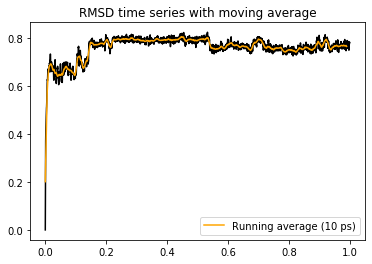

In [121]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

import seaborn as sns
target_roll = 10 # in picoseconds
rollwidth=round(target_roll/original_dt) # The width of the rolling window, in number of steps
rollingavg=moving_average(vrmsd,rollwidth)
# Plot the raw data:
sns.lineplot(x=vtimes/1000,y=vrmsd,color='black')
# Plot the moving average
roll_label="Running average (%d ps)" % target_roll
sns.lineplot(x=vtimes[:-rollwidth]/1000,y=rollingavg[:-rollwidth],label=roll_label,color="orange")
plt.title("RMSD time series with moving average")
plt.savefig("data/rmsd_rollingavg.png",dpi=300)